# Feasibility Analysis in MAGNUS

The module `NSFeas` in `MAGNUS` provides a set of methods to define and solve feasibility problems using nested sampling.  `NSFeas` leverages the DAG evaluation capability in `pyMC` to run the scenario simulations internally. Additionally, capability to embed ordinary differential equations (ODEs) into a DAG can be leveraged from `CRONOS` to enable dynamic feasibility analysis.

## Feasibility Analysis of a Pair of Algebraic Constraints

We consider the following example from [Kusumo _et al_ (2019)](https://doi.org/10.1021/acs.iecr.9b05006) with two design variables, ${\bf d}:=(d_1, d_2)^\intercal$ and a single output, $y$ given by:
$$\begin{align}
y = \theta d_1^2 + d_2
\end{align}$$
with the model parameter $\theta$. Our goal is to characterize the probabilistic feasible set inside the a priori domain $\mathcal{D}_0 \coloneqq [-1, 1]^2$ defined by the following pair of constraints:
$$\begin{equation}
0.20 \leq y \leq 0.75
\end{equation}$$
We want to characterize the nominal case corresponding to $\theta_{\rm nom}=1$::
$$\begin{align}
\mathcal{D}_{\rm nom} \coloneqq \{ {\bf d}\in \mathcal{D}_0: 0.20\leq d_1^2+d_2 \leq 0.75 \}
\end{align}$$
We also want to characterize the probabilistic case under a normality assumption for the model parameters, $\theta \sim \mathcal N(1,\sqrt{3})$:
$$\begin{align}
\mathcal{D}_\alpha \coloneqq  \left\{ {\bf d}\in \mathcal{D}_0: \mathbb{P}\left[0.20\leq \theta d_1^2+d_2 \leq 0.75 \:\middle|\: \theta \sim \mathcal N(1,\sqrt{3}) \right] \geq \alpha \right\}
\end{align}$$
with a feasibility probability $\alpha\geq 0.9$.

We start by importing both the `PyMC` and `MAGNUS` modules:

In [2]:
import pymc
from magnus import NSFeas

NSFeas.uniform_sampling( 10, [0,0], [1,1] )


[[0.5, 0.5],
 [0.75, 0.25],
 [0.25, 0.75],
 [0.375, 0.375],
 [0.875, 0.875],
 [0.625, 0.125],
 [0.125, 0.625],
 [0.1875, 0.3125],
 [0.6875, 0.8125],
 [0.9375, 0.0625]]

Next, we define the DAG of the growth model in `pyMC`:

In [3]:
# Create DAG
DAG = pymc.FFGraph()
DAG.options.MAXTHREAD = 1

d = DAG.add_vars( 2, "d" )
p = DAG.add_var( "p" )
#p.set( 1 );
y = p*d[0]**2 + d[1]
print( "y = ", y.str() )

y =  d1 + p * SQR( d0 )


We instantiate an environment `NSFeas` and set the relevant options:

In [4]:
# Instantiate nested sampler
NS = NSFeas()

NS.options.DISPLEVEL = 1
NS.options.FEASCRIT  = NS.options.VAR #CVAR
NS.options.FEASTHRES = 0.05
NS.options.NUMLIVE   = 1000
NS.options.NUMPROP   = 16
NS.options.MAXITER   = 0

NS.set_dag( DAG )
NS.set_constraint( [ y-0.75, 0.20-y ] )
NS.set_control( d, [ -1, -1 ], [ 1, 1 ] )

We start with the nominal scenario with $p=1$. After setup, we conduct a nested sampling using the method `sample`:

In [5]:
NS.set_parameter( [p], [1] );
NS.setup()
NS.sample()

** INITIALIZING LIVE POINTS (1000)      0.01 SEC

Iterate        Contour #Feas    #Dead         Factor
----------------------------------------------------
      0     1.2266e+00   268        0     3.0000e-01
     25     4.7517e-01   383      341     2.8028e-01
     50     2.8123e-01   492      587     2.6682e-01
     75     1.7784e-01   610      791     2.5615e-01
    100     1.0321e-01   714      952     2.4804e-01
    125     6.1259e-02   823     1089     2.4133e-01
    150     1.9789e-02   936     1219     2.3514e-01
    165     0.0000e+00  1000     1285     2.3206e-01


0

We can retrieve the live points, dead points, or discarded points for plotting from the respective fields `live_points`, `dead_points` and `discard_points`:

In [6]:
import numpy as np
np.set_printoptions( threshold=10 )

( points, feas, *other ) = NS.live_points
print( points, "\n", feas )

[[-0.33915332  0.36000586]
 [ 0.10546875  0.46484375]
 [ 0.25933837  0.40902248]
 ...
 [-0.42011816  0.57317087]
 [ 0.45853777 -0.01017389]
 [-0.5         0.5       ]] 
 [[-2.74969167e-01]
 [-2.74032593e-01]
 [-2.73721132e-01]
 ...
 [-3.29864019e-04]
 [-8.29973502e-05]
 [ 0.00000000e+00]]


A plot of the nominal feasible domain is shown below:

In [7]:
import matplotlib.pyplot as plt

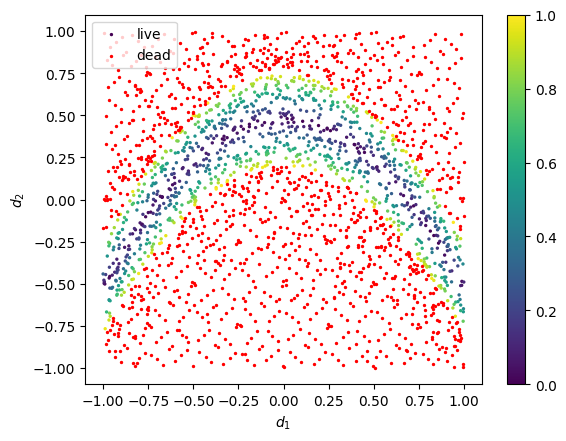

In [10]:
( livepoints, livefeas, *other ) = NS.live_points
( deadpoints, deadfeas, *other ) = NS.dead_points

plt.xlabel("$d_1$")
plt.ylabel("$d_2$")
plt.scatter(livepoints[:,0], livepoints[:,1], c=livefeas[:,0], s=2, cmap='viridis', label='live')
plt.scatter(deadpoints[:,0], deadpoints[:,1], c='r', s=2, label='dead')
plt.colorbar()
plt.legend(loc="best")
plt.show()

Next, we consider the probabilistic scenario with 100 samples drawn from $p\sim\mathcal{N}(1,\sqrt{3})$:

In [11]:
np.random.seed( 0 )
psam = []
[ psam.append( [ np.random.normal( 1, np.sqrt(3) ) ] ) for i in range(0,100) ]

NS.set_parameter( [p], psam );
NS.setup()
NS.sample()

** INITIALIZING LIVE POINTS (1000)      0.11 SEC

Iterate        Contour #Feas    #Dead         Factor
----------------------------------------------------
      0     4.2717e+00    53        0     3.0000e-01
     25     1.7642e+00    69      341     2.8028e-01
     50     1.2503e+00    89      602     2.6602e-01
     75     1.0270e+00   111      814     2.5498e-01
    100     8.4219e-01   144      992     2.4606e-01
    125     6.8048e-01   176     1173     2.3731e-01
    150     5.6074e-01   205     1332     2.2989e-01
    175     4.7339e-01   236     1474     2.2345e-01
    200     3.8802e-01   285     1638     2.1624e-01
    225     3.0583e-01   336     1807     2.0905e-01
    250     2.4645e-01   399     1967     2.0247e-01
    275     1.9133e-01   470     2127     1.9609e-01
    300     1.4240e-01   543     2290     1.8980e-01
    325     1.0175e-01   628     2439     1.8423e-01
    350     6.3644e-02   735     2590     1.7875e-01
    375     4.0084e-02   839     2726     1.7395e

0

A plot of the probabilistic feasible domain with infeasibility threshold set to 10% is shown below:

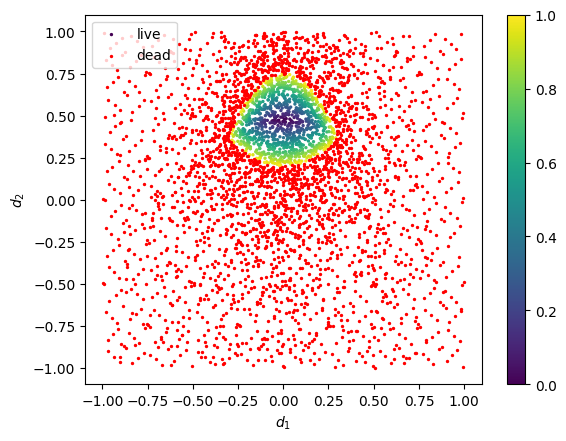

In [12]:
( livepoints, livefeas, *other ) = NS.live_points
( deadpoints, deadfeas, *other ) = NS.dead_points

plt.xlabel("$d_1$")
plt.ylabel("$d_2$")
plt.scatter(livepoints[:,0], livepoints[:,1], c=livefeas[:,0], s=2, cmap='viridis', label='live')
plt.scatter(deadpoints[:,0], deadpoints[:,1], c='r', s=2, label='dead')
plt.colorbar()
plt.legend(loc="best")
plt.show()

Finally, we illustrate how to pass a custom model from python into the DAG to solve the same problem:

In [13]:
def model( x ):
  return [ x[2]*x[0]**2 + x[1] ]

OpY = pymc.FFCustom()
OpY.set_D_eval( model )
y = OpY( d+[p], 0 )
print( "y = ", y.str() )


y =  Custom[0][0]( d0, d1, p )


In [14]:
NS.set_constraint( [ y-0.75, 0.20-y ] )
NS.setup()
NS.sample()

** INITIALIZING LIVE POINTS (1000)      0.14 SEC

Iterate        Contour #Feas    #Dead         Factor
----------------------------------------------------
      0     4.2717e+00    53        0     3.0000e-01
     25     1.7613e+00    78      335     2.8061e-01
     50     1.2590e+00    96      574     2.6752e-01
     75     1.0125e+00   123      791     2.5615e-01
    100     8.2104e-01   145      978     2.4675e-01
    125     6.8189e-01   171     1140     2.3889e-01
    150     5.6221e-01   203     1294     2.3164e-01
    175     4.6711e-01   242     1448     2.2461e-01
    200     3.6772e-01   293     1610     2.1745e-01
    225     2.9695e-01   348     1762     2.1094e-01
    250     2.3441e-01   397     1909     2.0483e-01
    275     1.8988e-01   454     2064     1.9858e-01
    300     1.4333e-01   523     2212     1.9279e-01
    325     1.0068e-01   628     2378     1.8649e-01
    350     6.1568e-02   746     2548     1.8026e-01
    375     3.0996e-02   862     2698     1.7493e

0

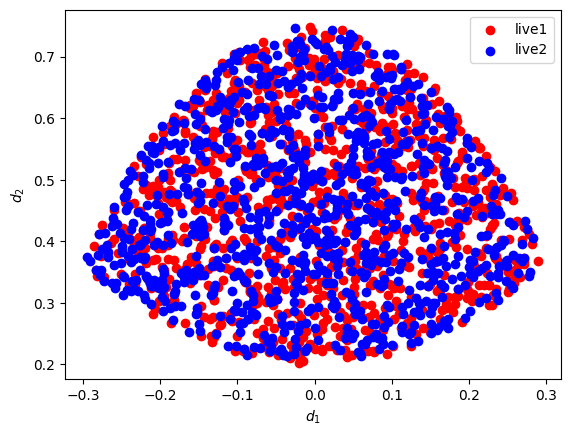

In [16]:
( livepoints2, livefeas2, *other ) = NS.live_points

plt.xlabel("$d_1$")
plt.ylabel("$d_2$")
plt.scatter(livepoints[:,0],  livepoints[:,1],  c='r', label='live1')
plt.scatter(livepoints2[:,0], livepoints2[:,1], c='b', label='live2')
plt.legend(loc="best")
plt.show()